In [337]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [338]:

import os
import json

# Data Wrangling
import h5py
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


### Preprocessing:

* ####  Tail smoothing (Filter + PCA)
* #### Segmentation (Sparse code + Threshold )
* #### Classification
* #### Make figure

### Compare Gold Standard with Matlab toolbox
* #### Make common dataframe with Tail active from both algorithm (use dataframe from G:\ZebrafishBoutsDataset for matlab reference)
* #### Compute confusion matrix for python gold standard (with different N in KNN) vs Matlab
* #### Compute confusion matrix for sparse coding segmentation vs threshold based



In [339]:
df = pd.read_csv('D:\ZebrafishMatlabCSV\CatchAllBouts_atlas_20200525_1551_df.csv')

In [340]:
df.columns

Index(['Unnamed: 0', 'x_blob', 'y_blob', 'x_mideye', 'y_mideye', 'body_angle',
       'tail_active', 'bout_cat_matlab', 'bout_sign_matlab', 'tail_angle_01',
       'tail_angle_02', 'tail_angle_03', 'tail_angle_04', 'tail_angle_05',
       'tail_angle_06', 'tail_angle_07', 'tail_angle_08', 'tail_angle_09',
       'tail_angle_10'],
      dtype='object')

# Tail Smoothing

In [5]:
from preprocessing.smoothing import clean_using_pca

In [6]:
# Set Nan when tail angle out of range:

NumSegment = sum(['tail_angle' in df.columns[i] for i in range(len(df.columns))])
relative_tail_angle = df[['tail_angle_'+str(i).zfill(2) for i in range(1,NumSegment+1)]]
relative_tail_angle = relative_tail_angle.values
tail_angle_init=np.cumsum(relative_tail_angle,1)
tail_angle = np.copy(tail_angle_init)

tail_angle[tail_angle<-10]=np.nan

# Interpolate NaN:
for s in range(tail_angle.shape[1]):
    ds = pd.Series(tail_angle[:,s])
    ds.interpolate(method='nearest',limit=5)
    tail_angle[:,s] = ds.values


# Set to 0 for long sequence of nan:
tail_angle[np.isnan(tail_angle)]=0

# Use PCA for Cleaning (Could use DMD for better results)
tail_angle = clean_using_pca(tail_angle,num_pcs=4)
T = tail_angle.shape[0]

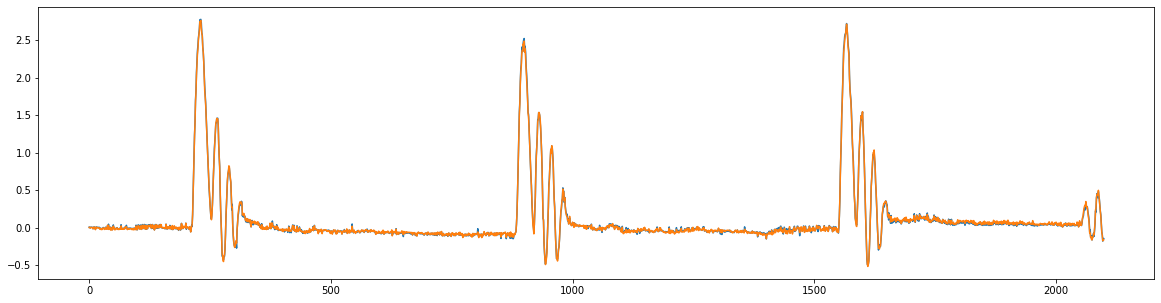

In [7]:
# Diagnostic Plot:
Duration = 700*3
IdSt = np.random.randint(T-Duration)
fig, (ax) = plt.subplots(1,1,figsize=(20,5), sharex=True)

ax.plot(tail_angle_init[IdSt:IdSt+Duration,7])
ax.plot(tail_angle[IdSt:IdSt+Duration,7])

plt.show()

# Segmentation using Sparse Coding

In [8]:
from preprocessing.baseline import remove_slow_trend

In [9]:
tail_angle_detrend = remove_slow_trend(tail_angle,ref_segment=7)
#TODO: Improve Detrending using speed (robust diff gives very good smoothing using filter~21 and could be used to remove slow trend)

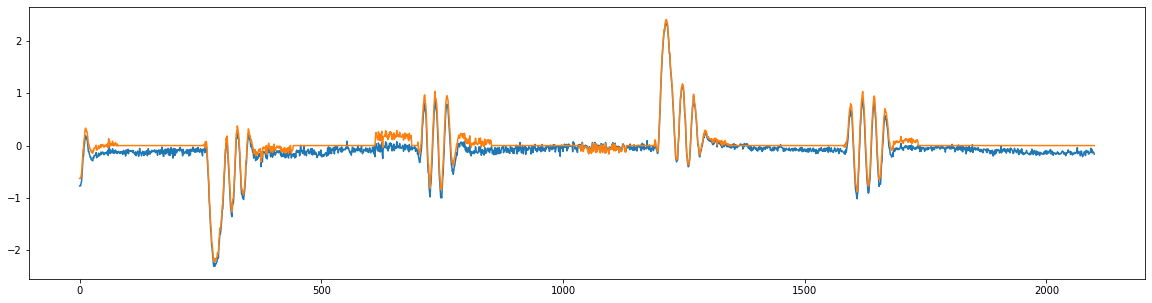

In [10]:
# Diagnostic Plot:
Duration = 700*3
IdSt = np.random.randint(T-Duration)
fig, (ax) = plt.subplots(1,1,figsize=(20,5), sharex=True)

ax.plot(tail_angle[IdSt:IdSt+Duration,7])
ax.plot(tail_angle_detrend[IdSt:IdSt+Duration,7])

plt.show()

(150, 7, 3)
(8908250, 10)


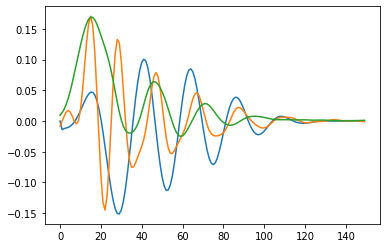

In [11]:
Dict = np.load('./sparse_coding/3atomsDictTu.npy')
N_atoms = Dict.shape[2]
Wg = np.ones((1,N_atoms))
print(Dict.shape)
print(tail_angle_detrend.shape)

plt.plot(Dict[:,-1,:])

In [12]:
from sparse_coding.sparse_coding import compute_sparse_code

In [13]:
z,tail_angle_hat = compute_sparse_code(tail_angle_detrend[:,:7],Dict,Wg,lmbda=0.01,gamma=0.05,mu=0.05,Whn=60)

Itn   Fnc       DFid      Regℓ1     RegLat    RegSelf   r         s         ρ       
------------------------------------------------------------------------------------
   0  5.87e+04  3.00e+04  3.51e+05  3.02e+05  2.01e+05  4.33e-01  2.00e+01  1.50e+00
   1  9.07e+04  2.22e+04  4.26e+05  7.57e+05  5.27e+05  5.58e-01  3.31e+00  1.50e+00
   2  1.12e+05  2.54e+04  4.11e+05  9.51e+05  6.90e+05  4.39e-01  4.69e-01  5.99e-01
   3  1.21e+05  2.59e+04  3.47e+05  1.02e+06  8.19e+05  3.16e-01  2.05e-01  5.99e-01
   4  1.20e+05  2.82e+04  2.94e+05  9.44e+05  8.30e+05  2.44e-01  1.52e-01  7.24e-01
   5  1.19e+05  2.97e+04  2.59e+05  8.78e+05  8.49e+05  1.60e-01  1.35e-01  8.93e-01
   6  1.22e+05  3.07e+04  2.51e+05  8.72e+05  9.09e+05  1.13e-01  1.11e-01  8.93e-01
   7  1.24e+05  3.10e+04  2.46e+05  8.65e+05  9.46e+05  9.84e-02  8.75e-02  8.93e-01
   8  1.24e+05  3.16e+04  2.37e+05  8.43e+05  9.63e+05  8.58e-02  7.25e-02  8.93e-01
   9  1.24e+05  3.22e+04  2.29e+05  8.13e+05  9.83e+05  7.11e-02 

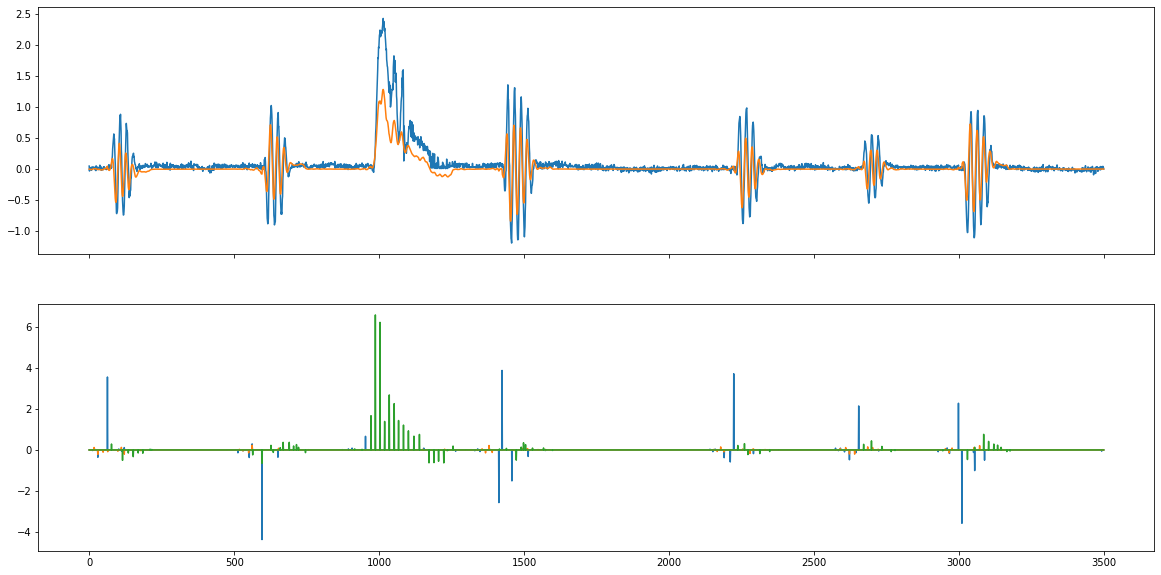

In [19]:
# Diagnostic Plot:
Duration = 700*5
IdSt = np.random.randint(T-Duration)
fig, (ax) = plt.subplots(2,1,figsize=(20,10), sharex=True)
ax[0].plot(tail_angle[IdSt:IdSt+Duration,7])
ax[0].plot(tail_angle_hat[IdSt:IdSt+Duration,-1])
ax[1].plot(z[IdSt:IdSt+Duration,:])
plt.show()

## Segmentation

In [20]:
from scipy.signal import find_peaks
z_normalized = np.copy(z)
#for i in range(z.shape[1]):
#    z_normalized[:,i] = z[:,i]/np.std(z[:,i])

z_max = np.max(np.abs(z_normalized),axis=1)
peaks, _ = find_peaks(z_max, height=1,distance=120)
peaks_bin = np.zeros(T)
peaks_bin[peaks]=1

## For each peak find next peak or gap in peaks...
Bout_Duration = 120
kernel = np.ones(Bout_Duration)
filtered_forward = np.convolve(kernel,peaks_bin, mode='full')[:peaks_bin.shape[0]]
is_tail_active = 1.0*(filtered_forward>0)#*(filtered_backward>0)

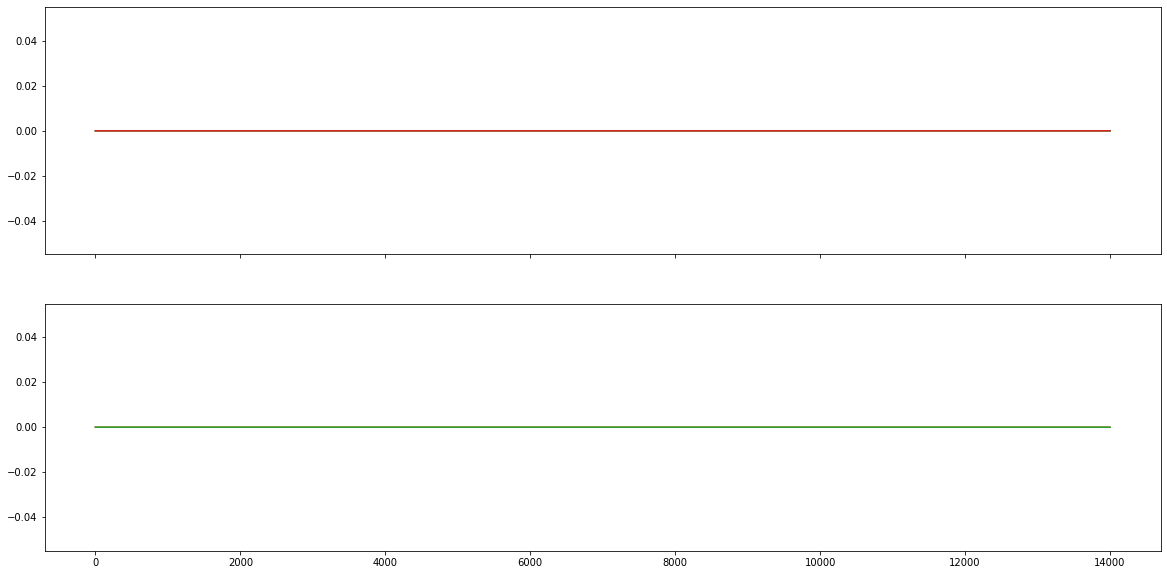

In [21]:
# Diagnostic Plot:
Duration = 700*20
IdSt = np.random.randint(T-Duration)
fig, (ax) = plt.subplots(2,1,figsize=(20,10), sharex=True)

ax[0].plot(z[IdSt:IdSt+Duration,:])
ax[0].plot(is_tail_active[IdSt:IdSt+Duration])

ax[1].plot(tail_angle_detrend[IdSt:IdSt+Duration,7])
ax[1].plot(tail_angle_hat[IdSt:IdSt+Duration,-1])

ax[1].plot(is_tail_active[IdSt:IdSt+Duration])

plt.show()

In [22]:
from segmentation.align import align_bout_peaks

In [26]:
bouts_array = np.zeros((len(peaks),140,7))
bouts_hat_array = np.zeros((len(peaks),140,7))

onset_list = []
offset_list = []
aligned_peaks = []

Margin_before_peak = 0
i = 0
for iter_,peak in enumerate(peaks):
        if ((peak>Margin_before_peak)&(peak+(140-Margin_before_peak)<T)):
            id_st = peak - Margin_before_peak
            id_ed = id_st +140
            tmp = tail_angle[id_st:id_ed,7]
            try:
                peak_location = align_bout_peaks(tmp,quantile_threshold = 0.25 , minimum_peak_size = 0.25, minimum_peak_to_peak_amplitude = 4,debug_plot_axes=None)
            except:
                peak_location = np.nan
                
            if np.isnan(peak_location):
                peak_location = peak
            else:
                aligned_peaks.append(id_st+peak_location)
                id_st = id_st+peak_location - Margin_before_peak-20
                id_ed = id_st +140
            bouts_array[i,:,:] = tail_angle[id_st:id_ed,:7]
            bouts_hat_array[i,:,:] = tail_angle_hat[id_st:id_ed,:]
            i = i+1
            onset_list.append(id_st)
            offset_list.append(id_ed)
            

bouts_array = bouts_array[:i,:,:]
bouts_hat_array = bouts_hat_array[:i,:,:]

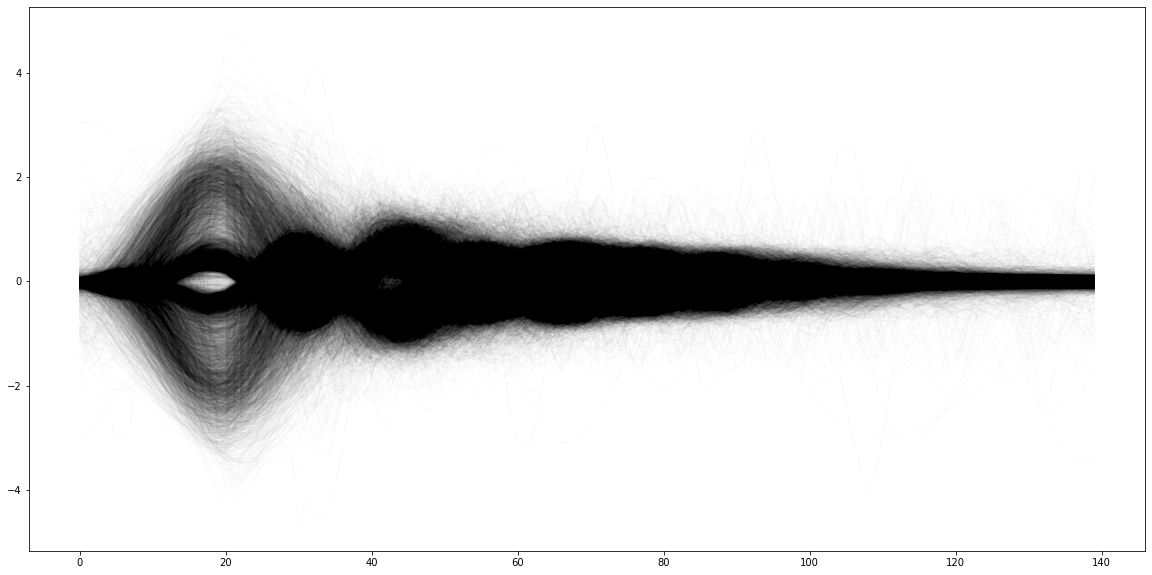

In [27]:

fig, (ax) = plt.subplots(1,1,figsize=(20,10))

for i in range(bouts_array.shape[0]):
    ax.plot(bouts_array[i,:,-1],'k',alpha=0.01)
plt.show()

# Classification

#TODO: RESCALE TRAJECTORY FROM MEANINGFULL UNITS TO NORMALIZATION:
    # OPPOSITE TO 
    # Rescale to meaningfull units: 
    ref_traj[:,0,:],ref_traj[:,1,:],ref_traj[:,2,:] = ref_traj[:,0,:]*5,ref_traj[:,1,:]*5,ref_traj[:,2,:]/2 # Rescaling to make x,y in mm and angle in radian


In [341]:
from classification.template_bouts import generate_template_bouts
from super_resolution.downsampling import convert_duration

In [343]:
'''bouts_array = bouts_array[:,:,:]
bouts_array_flat = np.reshape(np.swapaxes(bouts_array, 1, 2),(bouts_array.shape[0],bouts_array.shape[1]*bouts_array.shape[2]))
bouts_array_flat.shape
import matplotlib.gridspec as gridspec
from matplotlib import colors

fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}

for k,b in enumerate(np.unique((templates_labels))):
    b = int(b)
    sg = 1 if b<13 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])
    ax0.set_title(NameCat[b])
    
    
    id = np.where(bout_cat==b)[0]       
    if len(id)>0:
        id = id[0:1000]
        ax0.plot(bouts_array_flat[id,140*6:].T,'k',alpha=0.01)

    ax0.set_xlim(0,120)
    ax0.set_ylim(-3.6,3.6)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()

'''

"bouts_array = bouts_array[:,:,:]\nbouts_array_flat = np.reshape(np.swapaxes(bouts_array, 1, 2),(bouts_array.shape[0],bouts_array.shape[1]*bouts_array.shape[2]))\nbouts_array_flat.shape\nimport matplotlib.gridspec as gridspec\nfrom matplotlib import colors\n\nfig, ax = plt.subplots(facecolor='white',figsize=(20,10)) \n\nG = gridspec.GridSpec(2,13)\nax0 = {}\n\nfor k,b in enumerate(np.unique((templates_labels))):\n    b = int(b)\n    sg = 1 if b<13 else -1\n    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])\n    ax0.set_title(NameCat[b])\n    \n    \n    id = np.where(bout_cat==b)[0]       \n    if len(id)>0:\n        id = id[0:1000]\n        ax0.plot(bouts_array_flat[id,140*6:].T,'k',alpha=0.01)\n\n    ax0.set_xlim(0,120)\n    ax0.set_ylim(-3.6,3.6)\n    \n    ax0.set_xticks([])\n    ax0.set_yticks([])\n    \nplt.show()\n\n"

# Create pipeline

In [344]:
from preprocessing.smoothing import create_preprocess
from sparse_coding.sparse_coding import create_sparse_coder
from segmentation.segment import create_segmentation_from_code
from classification.classify import create_classifier
from classification.template_bouts import generate_template_bouts

from super_resolution.downsampling import convert_duration

In [345]:
def create_pipeline(preprocess,sparse_coder,segment_from_code,classifier):

    def pipeline(tail_angle):

        tail_angle_clean = preprocess(tail_angle)
        z,tail_angle_hat = sparse_coder(tail_angle_clean)
        onset,offset,bouts_array = segment_from_code(z,tail_angle)
        bouts_array_flat = np.reshape(np.swapaxes(bouts_array, 1, 2),(bouts_array.shape[0],bouts_array.shape[1]*bouts_array.shape[2]))
        bout_cat,delay_pred,id_nearest= classifier(bouts_array_flat)

        return tail_angle_clean,z,tail_angle_hat,onset,offset,bouts_array,bout_cat,delay_pred,id_nearest

    return pipeline

In [413]:


new_fps = 700
Max_Delay = convert_duration(70,original_fps=700,new_fps=new_fps)
Step_Delay = convert_duration(3,original_fps=700,new_fps=new_fps)

templates_flat,templates_labels,templates_delays,NameCat,Duration_after_Downsampling = generate_template_bouts(format='tail',target_fps=new_fps,ExludeCaptureSwim=True,delays=np.arange(-10,30,3))
#templates_flat,templates_labels,templates_delays,NameCat,Duration_after_Downsampling = generate_template_bouts(format='tail',target_fps=new_fps,ExludeCaptureSwim=True,delays=np.arange(0,Max_Delay,Step_Delay))

Dict = np.load('./sparse_coding/3atomsDictTu.npy')


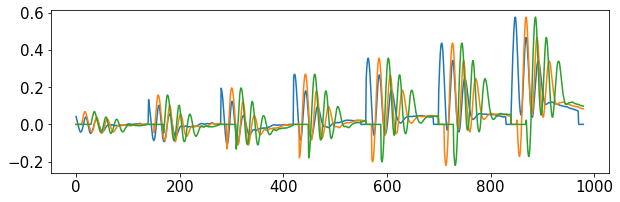

In [414]:

M = int(len(np.unique(templates_delays)))
N = int(len(templates_delays)/(M*2))
plt.figure(figsize=(10,3))

plt.plot(templates_flat[0,:])
plt.plot(templates_flat[0+N*int(np.round(M/2)),:])
plt.plot(templates_flat[0+N*(M-1),:])
plt.show()

In [440]:
bout_cat,delay_pred,id_nearest= classifier(bouts_array_flat)

In [ ]:

D = Dict

fig, (ax) = plt.subplots(1,3,figsize=(15,2), sharex=True,sharey=True)#,constrained_layout=True)

for i in range(D.shape[-1]):
    #ax[i].title(str(i))
    im = ax[i].imshow(D[:,:,i].T,aspect='auto',vmin=-0.2,vmax=0.2,cmap='bwr',extent=[0,100,1,0])
    ax[i].set_ylabel('tail segment')
    #ax[i,0].set_xlabel('Time (s)')
    ax[i].set_xticks(np.linspace(0,100,5))
    ax[i].set_xticklabels(np.round(np.linspace(0,100/700,5),2))


ax[0].set_xlabel('Time (s)')
ax[1].set_xlabel('Time (s)')
ax[2].set_xlabel('Time (s)')

cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.95)
cbar.set_label('Angle')
plt.show()

# TODO: USE SAME CLASSIFIER FOR ALL PIPELINE!!!!!!

In [415]:
# Check difference between tail or tail&traj or traj using the scale:
#scale = [1.6]*7+[0.5,0.4,1] # tail & traj
#scale = [0.5,0.4,1]  # traj
scale = [1]*7 # tail

In [416]:
preprocess = create_preprocess(limit_na=5,num_pcs=4)
sparse_coder = create_sparse_coder(Dict,lmbda=0.01,gamma=0.05,mu=0.05,Whn=60)
segment_from_code = create_segmentation_from_code(Min_Code_Ampl=1,SpikeDist=120,Bout_Duration=140)
classifier = create_classifier(templates_flat,templates_labels,templates_delays,scale,n_neighbors=5,Bout_Duration=140)
pipeline = create_pipeline(preprocess,sparse_coder,segment_from_code,classifier)

In [370]:
# Load Data

NumSegment = sum(['tail_angle' in df.columns[i] for i in range(len(df.columns))])
relative_tail_angle = df[['tail_angle_'+str(i).zfill(2) for i in range(1,NumSegment+1)]]
relative_tail_angle = relative_tail_angle.values
tail_angle_init=np.cumsum(relative_tail_angle,1)
tail_angle = np.copy(tail_angle_init)
tail_angle[tail_angle<-10]=np.nan # Set Nan when tail angle out of range:


In [371]:
tail_angle.shape

(8908250, 10)

In [372]:
#  Runing full pipeline
tail_angle_clean,z,tail_angle_hat,onset,offset,bouts_array,bout_cat,delay_pred,id_nearest = pipeline(tail_angle)

Itn   Fnc       DFid      Regℓ1     RegLat    RegSelf   r         s         ρ       
------------------------------------------------------------------------------------
   0  5.87e+04  3.00e+04  3.51e+05  3.02e+05  2.01e+05  4.33e-01  2.00e+01  1.50e+00
   1  9.07e+04  2.22e+04  4.26e+05  7.57e+05  5.27e+05  5.58e-01  3.31e+00  1.50e+00
   2  1.12e+05  2.54e+04  4.11e+05  9.51e+05  6.90e+05  4.39e-01  4.69e-01  5.99e-01
   3  1.21e+05  2.59e+04  3.47e+05  1.02e+06  8.19e+05  3.16e-01  2.05e-01  5.99e-01
   4  1.20e+05  2.82e+04  2.94e+05  9.44e+05  8.30e+05  2.44e-01  1.52e-01  7.24e-01
   5  1.19e+05  2.97e+04  2.59e+05  8.78e+05  8.49e+05  1.60e-01  1.35e-01  8.93e-01
   6  1.22e+05  3.07e+04  2.51e+05  8.72e+05  9.09e+05  1.13e-01  1.11e-01  8.93e-01
   7  1.24e+05  3.10e+04  2.46e+05  8.65e+05  9.46e+05  9.84e-02  8.75e-02  8.93e-01
   8  1.24e+05  3.16e+04  2.37e+05  8.43e+05  9.63e+05  8.58e-02  7.25e-02  8.93e-01
   9  1.24e+05  3.22e+04  2.29e+05  8.13e+05  9.83e+05  7.11e-02 

(14410, 980)

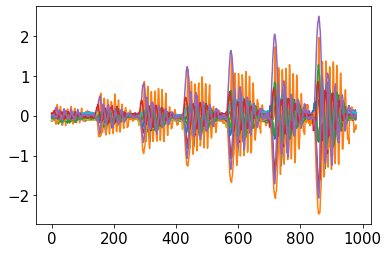

In [439]:
plt.plot(bouts_array_flat[::1000,:].T)
plt.show()

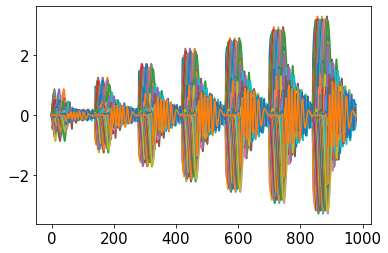

In [437]:
plt.plot(templates_flat[::1000,:].T)
plt.show()

In [ ]:
plt.plot(bouts_array)

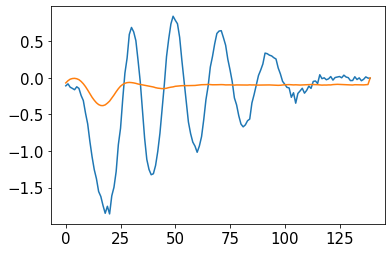

In [431]:
i = 0
x = bouts_array[i,:,:] 
j = int(id_nearest[i])
y = templates_flat[j,:].reshape(7,140)
plt.plot(x[:,-1])
plt.plot(y[-1,:])
plt.show()

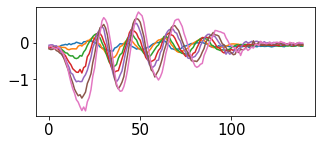

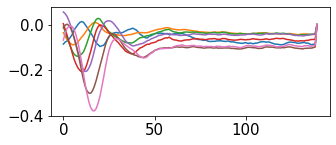

In [432]:
plt.figure(figsize=(5,2))
plt.plot(x)
plt.show()
plt.figure(figsize=(5,2))
plt.plot(y.T)
plt.show()

In [379]:
tail_angle.shape,tail_angle_hat.shape,tail_angle_clean.shape

((8908250, 10), (8908250, 7), (8908250, 10))

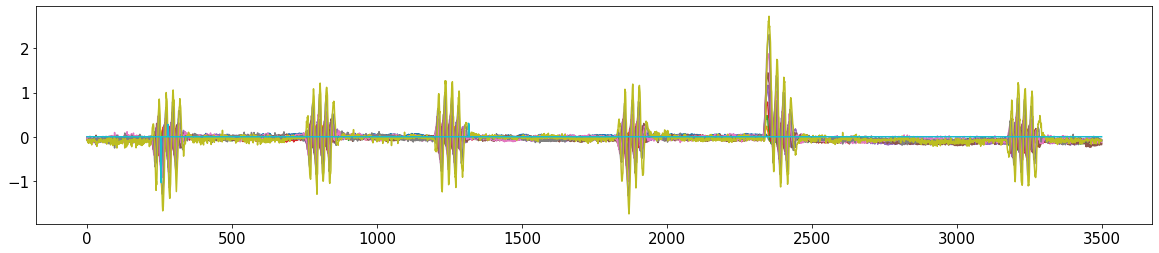

In [380]:
plt.figure(figsize=(20,4))
plt.plot(tail_angle[IdSt:IdSt+Duration,:])
plt.show()

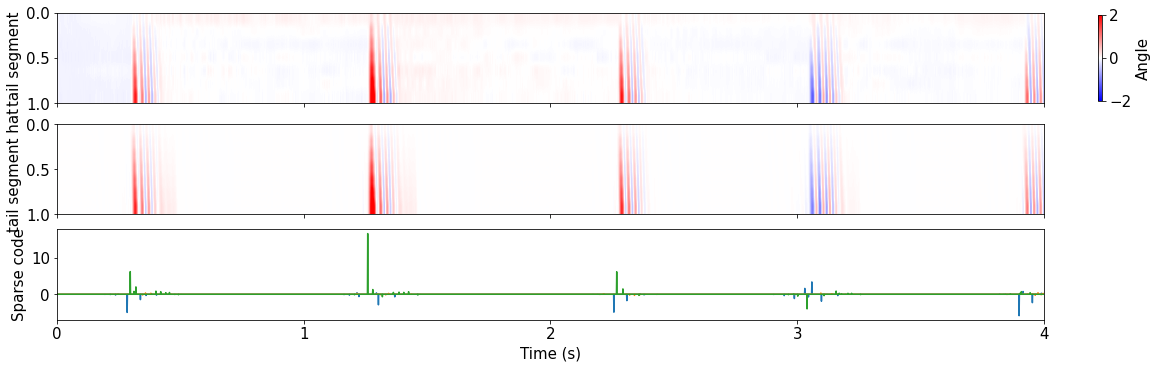

In [381]:
Duration = 700*5
IdSt= np.random.randint(z.shape[0]-Duration)

fig, (ax) = plt.subplots(3,1,figsize=(16,5), sharex=True,constrained_layout=True)
im = ax[0].imshow(tail_angle[IdSt:IdSt+Duration,:7].T,aspect='auto',extent=[0,Duration,1,0],vmin=-2,vmax=2,cmap='bwr',interpolation=None)
ax[0].set_ylabel('tail segment')
im = ax[1].imshow(tail_angle_hat[IdSt:IdSt+Duration,:7].T,aspect='auto',extent=[0,Duration,1,0],vmin=-2,vmax=2,cmap='bwr',interpolation=None)
ax[1].set_ylabel('tail segment hat')
ax[2].plot(z[IdSt:IdSt+Duration,:])
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Sparse code')
ax[2].set_xticks(np.linspace(0,Duration,5))

ax[2].set_xticklabels(np.arange(0,5))

cbar = fig.colorbar(im, ax=ax[0], shrink=0.95)
cbar.set_label('Angle')
plt.show()

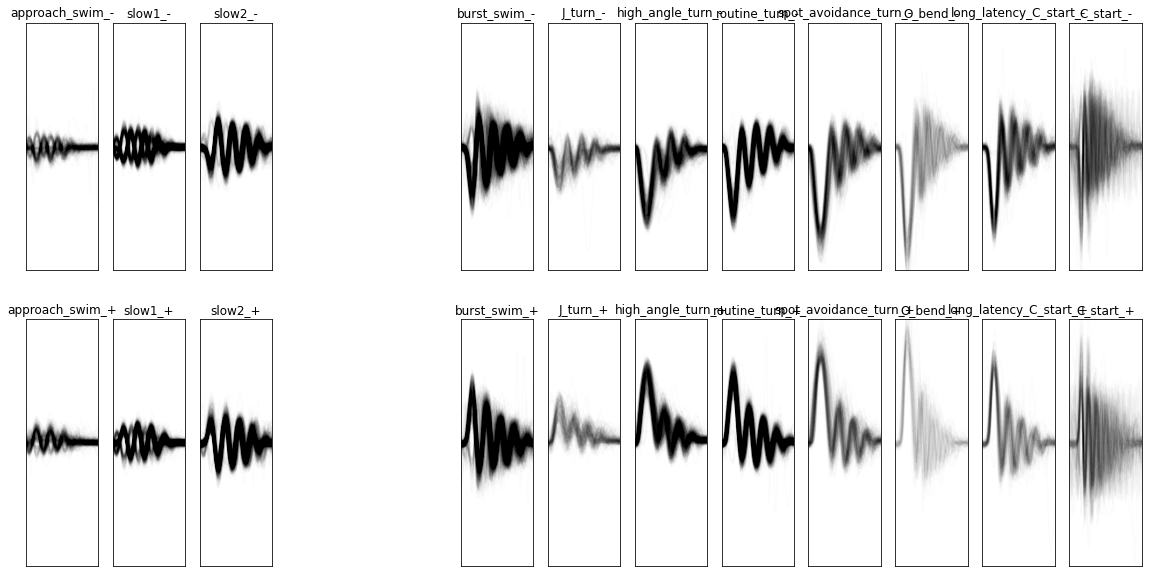

In [441]:
import matplotlib.gridspec as gridspec
from matplotlib import colors

fig, ax = plt.subplots(facecolor='white',figsize=(20,10)) 

G = gridspec.GridSpec(2,13)
ax0 = {}

for k,b in enumerate(np.unique((templates_labels))):
    b = int(b)
    sg = 1 if b<13 else -1
    ax0 = plt.subplot(G[int((sg+1)*1/2),b%13])
    ax0.set_title(NameCat[b])
    
    id = np.where(bout_cat==b)[0]       
    if len(id)>0:
        id = id[0:1000]
        ax0.plot(bouts_array[id,:,-1].T,'k',alpha=0.01)

    ax0.set_xlim(0,120)
    ax0.set_ylim(-3.6,3.6)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    
plt.show()


# Plotly Save

In [442]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px


In [443]:
from utils.utils_plot import NameCatSym_w_CS,list_color_w_CS,cmp_bouts

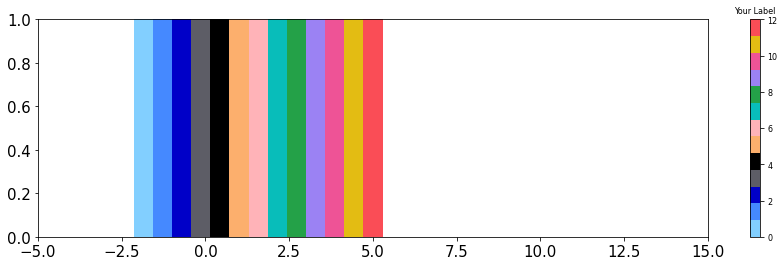

In [444]:
plt.figure(figsize=(15,4))
plt.imshow(np.arange(-5,30)[:,np.newaxis].T,cmap=cmp_bouts,aspect='auto',vmin=0,vmax=12,interpolation='nearest',extent=[-5,15,0,1])
clb=plt.colorbar()
clb.ax.tick_params(labelsize=8) 
clb.ax.set_title('Your Label',fontsize=8)
plt.show()

In [445]:
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale


In [446]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

cmp_bouts = colors.ListedColormap(['#FFFFFF'] + list_color_w_CS)


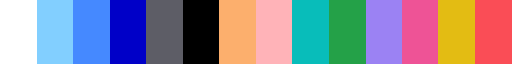

In [447]:
cmp_bouts

In [448]:
import plotly.express as px
import numpy as np

img = np.arange(-10,30).reshape(1,-1)
fig = px.imshow(img,color_continuous_scale=nipy_spectral,zmin=-1,zmax=13)

fig.write_html("free_swimming_pipeline.html")

In [449]:
s = 7
x = tail_angle_clean[:,s][:,np.newaxis]
y = np.zeros_like(x)
for on_,off_ in zip(onset,offset):
    y[on_:off_]=1
t = np.arange(len(x))[:,np.newaxis]

print(x.shape,y.shape,t.shape,z.shape)
df=pd.DataFrame(np.hstack((t,x,y,z)), columns=['t','tail','tail_active','code1','code2','code3'])
id_st = 700*60*0
id_ed = 700*60*20
df = df.iloc[id_st:id_ed]
sub_onset,sub_offset=[],[]

for on_,off_ in zip(onset,offset):
    if (on_>id_st)&(off_<id_ed):
        sub_onset.append(on_)
        sub_offset.append(off_)

(8908250, 1) (8908250, 1) (8908250, 1) (8908250, 3)


In [450]:
fig = make_subplots(rows=2, cols=1,shared_xaxes=True)

fig.add_trace(go.Scatter(x=df['t'], y=df['tail'],mode='lines'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=df['t'], y=df['tail_active'],mode='lines'),
              row=1, col=1)


for i,(on_,off_) in enumerate(zip(sub_onset[:200],sub_offset[:200])):
    if i%2==0:
        fig.add_vrect(x0=on_, x1=off_,line_width=0,fillcolor='#EDAE49',opacity=0.3,layer="below")
    else:
        fig.add_vrect(x0=on_, x1=off_,line_width=0,fillcolor='#D1495B',opacity=0.3,layer="below")

#fig.add_trace(go.Scatter(x=peaks, y=np.ones(len(peaks)),mode='markers'),
#              row=1, col=1)
fig.add_trace(go.Scatter(x=df['t'], y=df['code1'],mode='lines'),
              row=2, col=1)   
fig.add_trace(go.Scatter(x=df['t'], y=df['code2'],mode='lines'),
              row=2, col=1)   
fig.add_trace(go.Scatter(x=df['t'], y=df['code3'],mode='lines'),
              row=2, col=1)   

#fig['layout']['yaxis2'].update(title='', range=[0, 40], dtick=10, autorange=False)
#fig['layout']['yaxis1'].update(title='', range=[-3,3], dtick=10, autorange=False)

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.write_html("free_swimming_pipeline.html")


# Make FIGURE 2

In [451]:
from scipy.signal import find_peaks
z_normalized = np.copy(z)
#for i in range(z.shape[1]):
#    z_normalized[:,i] = z[:,i]/np.std(z[:,i])

z_max = np.max(np.abs(z_normalized),axis=1)
peaks, _ = find_peaks(z_max, height=1,distance=120)
peaks_bin = np.zeros(T)
peaks_bin[peaks]=1

## For each peak find next peak or gap in peaks...
Bout_Duration = 120
kernel = np.ones(Bout_Duration)
filtered_forward = np.convolve(kernel,peaks_bin, mode='full')[:peaks_bin.shape[0]]
is_tail_active = 1.0*(filtered_forward>0)#*(filtered_backward>0)

In [452]:

Duration = 700*7
IdSt = np.random.randint(z.shape[0])
IdEd = IdSt + Duration
t = np.linspace(0,Duration/700,Duration)
sub_onset,sub_offset,sub_i= [],[],[]

for i,(on_,off_) in enumerate(zip(onset,offset)):
    if (on_>IdSt)&(off_<IdEd):
        sub_onset.append(on_)
        sub_offset.append(off_)
        sub_i.append(i)

sub_peaks = np.where(peaks_bin[IdSt:IdEd]==1)[0]
sub_i = np.array(sub_i)

In [453]:
## For each bous in interval find nearest neighbor

from sklearn.neighbors import KNeighborsClassifier

print(bouts_array.shape,len(onset))

sub_bouts_array = bouts_array[sub_i]
print(sub_bouts_array.shape)


# FLATTEN ARRAY:
sub_bouts_array = sub_bouts_array[:,:,:]
sub_bouts_array_flat = np.reshape(np.swapaxes(sub_bouts_array, 1, 2),(sub_bouts_array.shape[0],sub_bouts_array.shape[1]*sub_bouts_array.shape[2]))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(templates_flat, templates_labels)
res = knn.kneighbors(sub_bouts_array_flat)
Nearest_bouts = templates_flat[res[1][:,0],140*6:]

(14410, 140, 7) 14410
(8, 140, 7)


In [454]:
from matplotlib.patches import Rectangle

(0.0, 7.0)

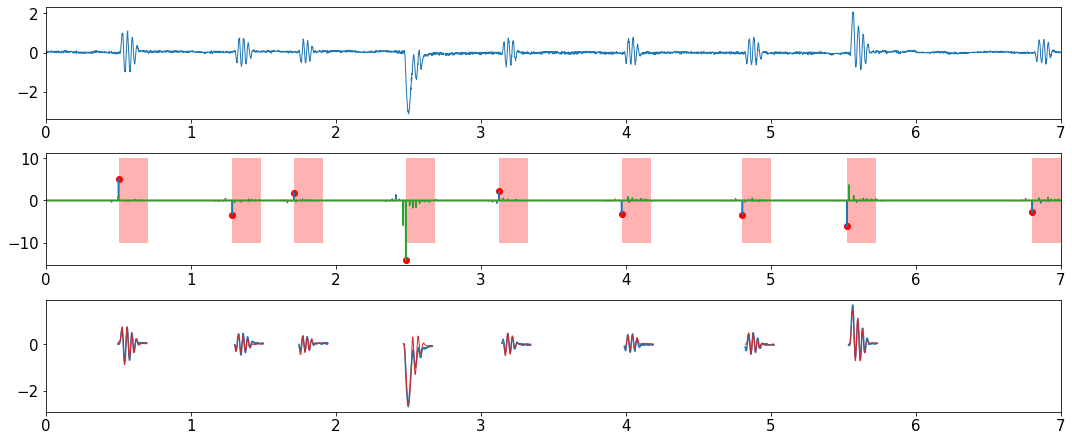

In [455]:

fig, ax = plt.subplots(facecolor='white',figsize=(15,10),tight_layout=True,sharex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(5,1)

ax = plt.subplot(G[0])
#ax.plot(t,tail_angle[IdSt:IdEd,7],'k',lw=1)
ax.plot(t,tail_angle_clean[IdSt:IdEd,7],lw=1)
ax.set_xlim(0,Duration/700)

ax = plt.subplot(G[1])
ax.plot(t,z[IdSt:IdEd,:])
y =-(1-2*(np.max((z[IdSt:IdEd]),axis=1)>np.max(-(z[IdSt:IdEd]),axis=1)))*np.max(np.abs(z[IdSt:IdEd]),axis=1)*peaks_bin[IdSt:IdEd]
ax.scatter(t[sub_peaks],y[sub_peaks],color = 'r')
for p in sub_peaks:
    ax.add_patch(Rectangle((t[p],-10),140/700,20,facecolor="red",alpha=0.3))
#ax.vlines(t[sub_peaks],-10,10)
ax.set_xlim(0,Duration/700)

ax = plt.subplot(G[2])
for i,(on_,off_) in enumerate(zip(sub_onset,sub_offset)):
    ax.plot((np.arange(on_,off_)-IdSt)/700,tail_angle_clean[on_:off_,6],'tab:blue')
    off_ = on_+140
    ax.plot((np.arange(on_,off_)-IdSt)/700,Nearest_bouts[i,:],'tab:red',lw=1)
 
ax.set_xlim(0,Duration/700)

In [456]:
Dict.shape

(150, 7, 3)

In [457]:

decomposition = np.zeros((z.shape[1],tail_angle.shape[0]))
for j in range(z.shape[1]):
    tmp =  np.convolve(z[:,j],Dict[:,-1,j],'full')
    decomposition[j,:] = tmp[:tail_angle.shape[0]]
decomposition = decomposition.T

[0 1 2]


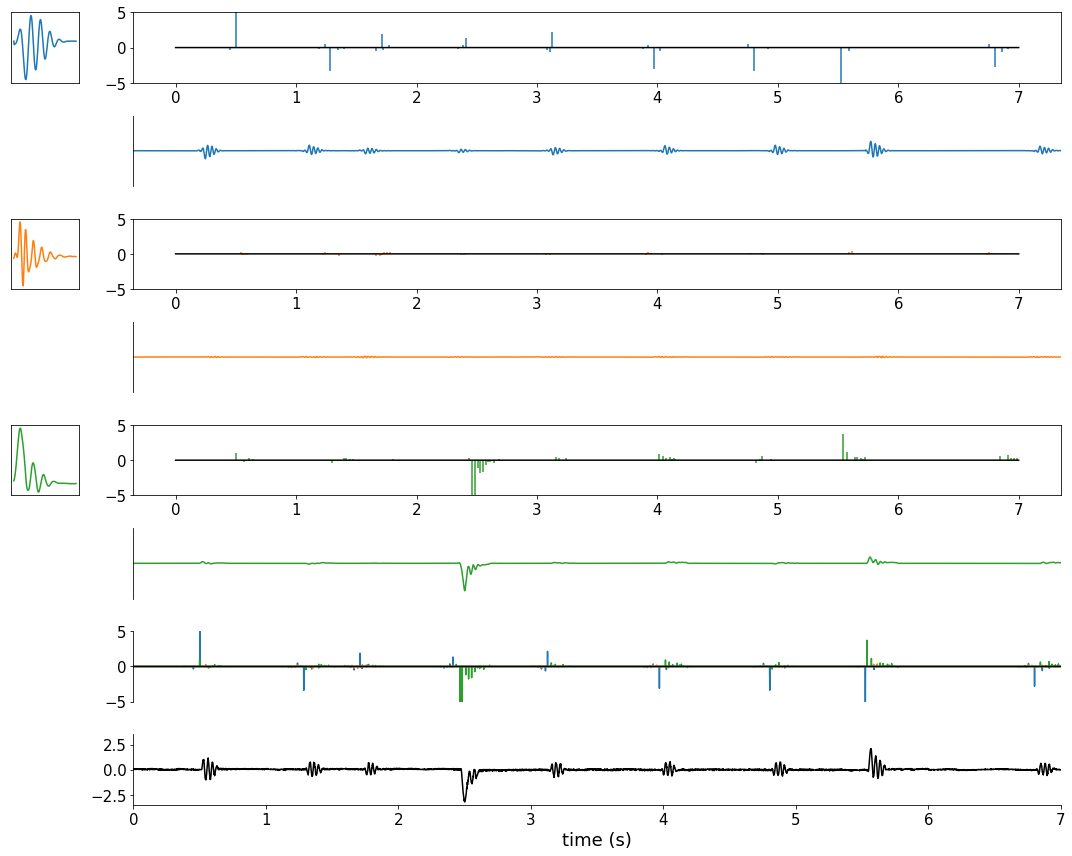

In [466]:
code = np.copy(z)
t = np.arange(0,Duration)/700
id_atom = np.where(np.sum(np.abs(code[IdSt:IdEd,:]),axis=0)>5)[0]

#id_atom = [i for i in ordered_atom if np.any(np.isin(id_atom,i))]
print(id_atom)
N = len(id_atom)
cmap = plt.cm.tab10  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

fig, ax = plt.subplots(facecolor='white',figsize=(15,12),tight_layout=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)

G = gridspec.GridSpec(2*N+2,9)

ax = plt.subplot(G[-1:,1:])
ax.plot(t,tail_angle[IdSt:IdEd,7],'k')
ax.set_ylim(-3.5,3.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0,Duration/700)
ax.set_xlabel('time (s)',fontdict={'fontsize':18})
#ax.set_ylabel('tail angle \n (rad)',fontdict={'fontsize':18},rotation='horizontal')

ax = plt.subplot(G[-2,1:])
for i,i_code in enumerate(id_atom):
    ax.plot(t,code[IdSt:IdEd,i_code],color=cmaplist[i])
ax.plot(t,code[IdSt:IdEd,i_code]*0,color='k')
ax.set_xticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim(0,Duration/700)
ax.set_ylim(-5,5)
#ax.set_ylabel('sparse code',fontdict={'fontsize':18},rotation='horizontal')

# ax.set_ylim(-3,3)
markerline = {}
stemline = {}
k=0
for i,i_code in enumerate(id_atom):
    ax = plt.subplot(G[k,1:])
    ax.plot(t,code[IdSt:IdEd,i_code]*0,color='k')
    y = code[IdSt:IdEd,i_code]
    x = t
    x = x[np.abs(y)>0.1]
    y = y[np.abs(y)>0.1]

    if len(x)>0:
        markerline[i], stemline[i], baseline = ax.stem(x,y,use_line_collection=True)
        baseline.remove()
        markerline[i].remove()
        #plt.setp(markerline[i], color=cmaplist[i]) 
        plt.setp(stemline[i], color=cmaplist[i])
    ax.set_ylim(-5,5)

    
    ax = plt.subplot(G[k+1,1:])
    ax.plot(t,decomposition[IdSt:IdEd,i_code],color=cmaplist[i])
        
    ax.set_ylim(-3.5,3.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlim(0,Duration/700)

    ax = plt.subplot(G[k:k+1,0])
    ax.plot(Dict[:,-1,i_code],color=cmaplist[i])
    ax.set_xticks([])
    ax.set_yticks([])

    k=k+2


#plt.savefig('SparseCoding_'+strain+'.png',dpi=300, bbox_inches = "tight")

plt.show()